# Dense neural network
Author: Javier Duarte

# Table of Contents
* [Dense neural network](#Dense-neural-network)
* [Plotting inputs weighted by prediction](#Plotting-inputs-weighted-by-prediction)

## Loading libraries
First we load the relevant libraries.

In [14]:
import os
import sys
import glob

## Loading numpy arrays
Now we load two different numpy outputs. One corresponding to the VV signal and one corresponding to the gg background.

In [2]:
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
VARS = ['f_massjj','f_deltajj']
filename = {}
h5file = {}
params = {}
df = {}

filename['VV'] = 'data/ntuple_4mu_VV.h5'
filename['gg'] = 'data/ntuple_4mu_gg.h5'

h5file['VV'] = h5py.File(filename['VV'], 'r') # open read-only
params['VV'] = h5file['VV'][treename][()]
h5file['gg'] = h5py.File(filename['gg'], 'r') # open read-only
params['gg'] = h5file['gg'][treename][()]

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-pippkgs_depscipy/3.0-omkpbe4/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Convert to Pandas DataFrame
Now we can convert the numpy arrays to data frames. First we can look at the features that are available. 

To start with, we'll just take two inputs (`f_massjj`, `f_deltajj`).

In [3]:
df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['gg'] = pd.DataFrame(params['gg'],columns=VARS)

df['VV']= df['VV'][(df['VV'].f_massjj > 0) & (df['VV'].f_deltajj > 0)] # cut out undefined variables
df['gg']= df['gg'][(df['gg'].f_massjj > 0) & (df['gg'].f_deltajj > 0)] # cut out undefined variables

df['VV']['isSignal'] = np.ones(len(df['VV'])) # add isSignal variable
df['gg']['isSignal'] = np.zeros(len(df['gg'])) # add isSignal variable

# Dense neural network
## Defining our model (neural net topology)
We'll start with a densely-connected NN layer. Our model will have a single fully connected hidden layer with the same number of neurons as input variables. The weights are initialized using a small Gaussian random number. The Rectifier activation function is used. The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1 that can easily and automatically be converted to class values (0 or 1).

Finally, we are using the logarithmic loss function (`binary_crossentropy`) during training, a standard loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.

In [4]:
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name = 'input')    
x = Dense(20, name = 'dense_1', kernel_initializer='normal', activation='relu')(inputs)
x = Dense(20, name = 'dense_2', kernel_initializer='normal', activation='relu')(x)
x = Dense(20, name = 'dense_3', kernel_initializer='normal', activation='relu')(x)
predictions = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(x)
# This creates a model that includes
# the input layer and two dense layers (one output)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
output (Dense)               (None, 1)                 21        
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). We will also define our early stopping criteria to prevent over-fitting.

In [5]:
df_all = pd.concat([df['VV'],df['gg']])
dataset = df_all.values
X = dataset[:,0:NDIM].astype(float)
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
    
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

## Run training and visualize performance with ROC curves
Here, we run the training and visualize the performance of our model with a ROC curve for each cross validation sample.

In [6]:
# Train classifier
history = model.fit(X_train_val, Y_train_val, epochs=200, batch_size=1024, verbose=1, callbacks=[early_stopping], validation_split=0.25)

Train on 11324 samples, validate on 3775 samples
Epoch 1/200
11324/11324 [==============================] - 1s 64us/step - loss: 0.5867 - acc: 0.7058 - val_loss: 0.4649 - val_acc: 0.8392
Epoch 2/200
11324/11324 [==============================] - 0s 3us/step - loss: 0.4224 - acc: 0.8278 - val_loss: 0.3826 - val_acc: 0.8392
Epoch 3/200
11324/11324 [==============================] - 0s 3us/step - loss: 0.3814 - acc: 0.8278 - val_loss: 0.3791 - val_acc: 0.8392
Epoch 4/200
11324/11324 [==============================] - 0s 3us/step - loss: 0.3831 - acc: 0.8278 - val_loss: 0.3776 - val_acc: 0.8392
Epoch 5/200
11324/11324 [==============================] - 0s 3us/step - loss: 0.3795 - acc: 0.8278 - val_loss: 0.3772 - val_acc: 0.8392
Epoch 6/200
11324/11324 [==============================] - 0s 3us/step - loss: 0.3797 - acc: 0.8278 - val_loss: 0.3773 - val_acc: 0.8392
Epoch 7/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3795 - acc: 0.8278 - val_loss: 0.3766 - val_acc

11324/11324 [==============================] - 0s 4us/step - loss: 0.3793 - acc: 0.8278 - val_loss: 0.3759 - val_acc: 0.8392
Epoch 61/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3789 - acc: 0.8278 - val_loss: 0.3763 - val_acc: 0.8392
Epoch 62/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3790 - acc: 0.8278 - val_loss: 0.3759 - val_acc: 0.8392
Epoch 63/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3793 - acc: 0.8278 - val_loss: 0.3758 - val_acc: 0.8392
Epoch 64/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3792 - acc: 0.8278 - val_loss: 0.3760 - val_acc: 0.8392
Epoch 65/200
11324/11324 [==============================] - 0s 5us/step - loss: 0.3794 - acc: 0.8278 - val_loss: 0.3763 - val_acc: 0.8392
Epoch 66/200
11324/11324 [==============================] - 0s 5us/step - loss: 0.3790 - acc: 0.8278 - val_loss: 0.3758 - val_acc: 0.8392
Epoch 67/200
11324/11324 [=====================

11324/11324 [==============================] - 0s 4us/step - loss: 0.3779 - acc: 0.8278 - val_loss: 0.3743 - val_acc: 0.8392
Epoch 120/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3778 - acc: 0.8278 - val_loss: 0.3743 - val_acc: 0.8392
Epoch 121/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3782 - acc: 0.8278 - val_loss: 0.3742 - val_acc: 0.8392
Epoch 122/200
11324/11324 [==============================] - 0s 3us/step - loss: 0.3783 - acc: 0.8278 - val_loss: 0.3742 - val_acc: 0.8392
Epoch 123/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3786 - acc: 0.8278 - val_loss: 0.3743 - val_acc: 0.8392
Epoch 124/200
11324/11324 [==============================] - 0s 5us/step - loss: 0.3777 - acc: 0.8278 - val_loss: 0.3740 - val_acc: 0.8392
Epoch 125/200
11324/11324 [==============================] - 0s 5us/step - loss: 0.3777 - acc: 0.8278 - val_loss: 0.3741 - val_acc: 0.8392
Epoch 126/200
11324/11324 [==============

11324/11324 [==============================] - 0s 4us/step - loss: 0.3767 - acc: 0.8275 - val_loss: 0.3701 - val_acc: 0.8366
Epoch 179/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3757 - acc: 0.8274 - val_loss: 0.3703 - val_acc: 0.8360
Epoch 180/200
11324/11324 [==============================] - 0s 3us/step - loss: 0.3758 - acc: 0.8269 - val_loss: 0.3694 - val_acc: 0.8368
Epoch 181/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3753 - acc: 0.8266 - val_loss: 0.3700 - val_acc: 0.8366
Epoch 182/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3763 - acc: 0.8265 - val_loss: 0.3699 - val_acc: 0.8360
Epoch 183/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3746 - acc: 0.8265 - val_loss: 0.3694 - val_acc: 0.8363
Epoch 184/200
11324/11324 [==============================] - 0s 4us/step - loss: 0.3752 - acc: 0.8268 - val_loss: 0.3704 - val_acc: 0.8368
Epoch 185/200
11324/11324 [==============

In [7]:
import matplotlib.pyplot as plt

# Plot ROC
Y_predict = model.predict(X_test)

# Compute ROC curve and area the curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='cyan', label='ROC auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
df_all['dense'] = model.predict(X) # add prediction to array
print df_all.iloc[:5]

      f_massjj  f_deltajj  isSignal     dense
0  1300.426880   5.128572       1.0  0.973496
1   437.221863   3.278692       1.0  0.813940
3  1021.744080   5.989169       1.0  0.964100
4  1101.381958   5.170628       1.0  0.962062
7   498.717194   4.895020       1.0  0.881211


# Plotting inputs weighted by prediction
Let's see if we can shape the data distribution using the model weights and recover the ground truth

In [15]:
'''
HINT: 
Copy the example from "Plotting inputs" and use the weights=weights option of df.plot.hist
'''

'\nHINT: \nCopy the example from "Plotting inputs" and use the weights=weights option of df.plot.hist\n'

# Plot NN output vs input variables

In [10]:
'''
HINT: 
Think about what meshgrid is doing and what myZI should be to make
'''
myX = np.linspace(0, 7000, 70)
myY = np.linspace(0, 10, 70)
myXI, myYI = np.meshgrid(myX,myY)
myZI = np.array(myXI, copy=True)  
def predict(x, y):
    for i in range(0, len(x)):
        for j in range(0, len(y)):
            #x[i,j] # x value of i, j point
            #y[i,j] # y value of i, j point
            #myZI[i,j] = 0 # change this
            myarray = np.array([x[i,j], y[i,j]])
            myarray = myarray.reshape(1,2)
            myZI[i,j] = model.predict(myarray)
    return myZI
myZI = predict(myXI, myYI)

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.14.1-omkpbe2/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.14.1-omkpbe2/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


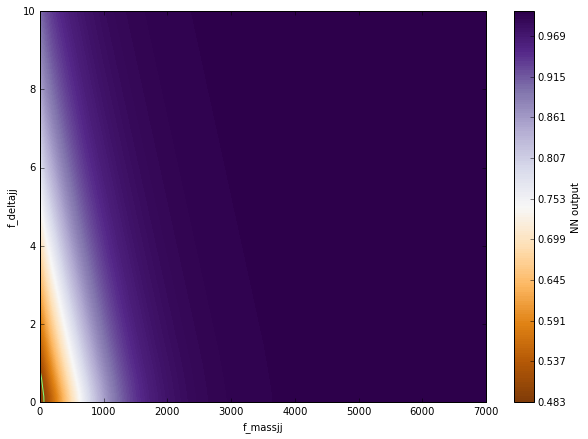

In [11]:
#from matplotlib.axes.Axes import set_xlim
plt.figure(figsize=(10,7))
plt.contourf(myXI,myYI,myZI, 200, cmap='PuOr')
plt.colorbar(boundaries=[0,1],label='NN output')
plt.contour(myXI,myYI,myZI, 3, levels=[0,0.5,1])
#X = {}
#X['VV'] = df['VV'].values[:,0:NDIM].astype(float)
#X['gg'] = df['gg'].values[:,0:NDIM].astype(float)
#plt.scatter(X['gg'][:,0],X['gg'][:,1],c='orange',alpha=0.3,s=10,marker="s",linewidths=0.2, edgecolor='white')
#plt.scatter(X['VV'][:,0],X['VV'][:,1],c='purple',alpha=0.3,s=10,linewidths=0.2,edgecolor='white')
plt.xlim(0,7000)
plt.ylim(0,10)
plt.xlabel(VARS[0])
plt.ylabel(VARS[1])

# Add NN output to friend ROOT trees

In [16]:
from root_numpy import root2array, array2root


def get_features_from_file(filename='', treename='', branches=[]):
    t = root2array(filename, treename=treename, branches=branches) # structured numpy array 
    #print t.shape 
    t = t.view(np.float32).reshape(t.shape + (-1,)) # normal numpy array (trick from https://stackoverflow.com/questions/5957380/convert-structured-array-to-regular-numpy-array)
    #print t.shape
    return t

def write_prediction_to_file(features, model, filename='',treename='',branch=''):
    y_predict_all = model.predict(features) # normal numpy array
    #print y_predict_all.shape
    y_predict_all = np.array(y_predict_all, dtype=[(branch, np.float32)]) # structured numpy array
    #print y_predict_all.shape
    array2root(y_predict_all, filename, treename=treename, mode='recreate')
    
X_all = get_features_from_file('data/ntuple_4mu_VV.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_VV_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

X_all = get_features_from_file('data/ntuple_4mu_gg.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_gg_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')